# Deep Learning with python Keras
## Chapter 7: Advanced deep learning best practices
### 7.2 Inspecting and monitering deep learning models: using Keras callbacks and TensorBoard

#### 7.2.1 Using callbacks to act on model during training 

In [1]:
import keras
from keras import Input, layers, losses, optimizers, metrics, models
from keras.datasets import  imdb
from keras.preprocessing import sequence
from keras.models import Sequential, Model
import numpy as np
from keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

Using TensorFlow backend.


In [2]:
# set the results file path
sectionnum = '7_2'
cur_work_path = os.getcwd()
res_path = '{}/res_c{}'.format(cur_work_path,sectionnum)
if not os.path.exists(res_path):
    os.mkdir(res_path)

In [3]:
# using a simple rnn model we used in C6.2 section
# params
max_features = 10000 # number of words to condier as features
maxlen = 500 # cut texts after this number of words
batchsize = 32

# loading and prepare the data
print('loading data ...')
(input_train, y_train),(input_test, y_test) = imdb.load_data(num_words=max_features)
print('len of train: ', len(input_train))
print('len of test: ', len(input_test))
# for the running-speed consideration, we just use part of the data
input_train = input_train[:8000]
y_train = y_train[:8000]

print('shape and type of input_train before padding: ', input_train.shape, type(input_train))
input_train = sequence.pad_sequences(input_train,maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('shape and type of input_train after padding: ', input_train.shape, type(input_train))
# crate the model
def CreateModel(rnn = layers.SimpleRNN, hiddensize=32):
    model = models.Sequential()
    model.add(layers.Embedding(max_features,32))
    model.add(rnn(hiddensize))
    model.add(layers.Dense(1,activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

loading data ...
len of train:  25000
len of test:  25000
shape and type of input_train before padding:  (8000,) <class 'numpy.ndarray'>
shape and type of input_train after padding:  (8000, 500) <class 'numpy.ndarray'>


In [4]:
# Using callbacks: EarlyStopping and ModelCheckpoint
callbacks_list = [
    # This callback will inerrupt training when we have stopped improving
    keras.callbacks.EarlyStopping(
        # This callback will monitor the validation accuracy of the model
        monitor='acc',
        # Training will be interruped when the accuracy has stopped improving for more than
        # 1 epochs (i.e. 2 epchs)
        patience=1,
    ),
    keras.callbacks.ModelCheckpoint(
        # Path to the destination model file
        filepath='call_back_checkpoint',
        # monitor the 'val_loss'
        monitor='val_loss',
        # allow us to keep the best model every seen during training
        save_best_only=True,
    )
]

In [8]:
# training without the callback
history_record=[]
model = CreateModel(layers.GRU)
history = model.fit(input_train,y_train,epochs=20,batch_size=512,validation_split=0.2)
history_record.append(history)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.6902 - acc: 0.5427 - val_loss: 0.6845 - val_acc: 0.5975
Epoch 2/20
6400/6400 [==============================] - 10s 2ms/step - loss: 0.6631 - acc: 0.6698 - val_loss: 0.6332 - val_acc: 0.6863
Epoch 3/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.6220 - acc: 0.7400 - val_loss: 0.5792 - val_acc: 0.7450
Epoch 4/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.5026 - acc: 0.8092 - val_loss: 0.5055 - val_acc: 0.7612
Epoch 5/20
6400/6400 [==============================] - 13s 2ms/step - loss: 0.4131 - acc: 0.8513 - val_loss: 0.4835 - val_acc: 0.7756
Epoch 6/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.3620 - acc: 0.8716 - val_loss: 0.5160 - val_acc: 0.7362
Epoch 7/20
6400/6400 [==============================] - 12s 2ms/step - loss: 0.3292 - acc: 0.8888 - val_loss: 0.4186 - val_acc: 0.8137
Epoch 8

In [9]:
# training with the callback
model1 = CreateModel(layers.GRU)
history = model1.fit(input_train,y_train,epochs=20,batch_size=512,validation_split=0.2,
                    callbacks=callbacks_list)
history_record.append(history)

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.6893 - acc: 0.5595 - val_loss: 0.6812 - val_acc: 0.6075
Epoch 2/20
6400/6400 [==============================] - 13s 2ms/step - loss: 0.6608 - acc: 0.6783 - val_loss: 0.6398 - val_acc: 0.6694
Epoch 3/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.5979 - acc: 0.7552 - val_loss: 0.5597 - val_acc: 0.7462
Epoch 4/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.4726 - acc: 0.8164 - val_loss: 0.4923 - val_acc: 0.7831
Epoch 5/20
6400/6400 [==============================] - 12s 2ms/step - loss: 0.4093 - acc: 0.8527 - val_loss: 0.4677 - val_acc: 0.7900
Epoch 6/20
6400/6400 [==============================] - 11s 2ms/step - loss: 0.3488 - acc: 0.8744 - val_loss: 0.4410 - val_acc: 0.8006
Epoch 7/20
6400/6400 [==============================] - 12s 2ms/step - loss: 0.3930 - acc: 0.8516 - val_loss: 0.4493 - val_acc: 0.7937


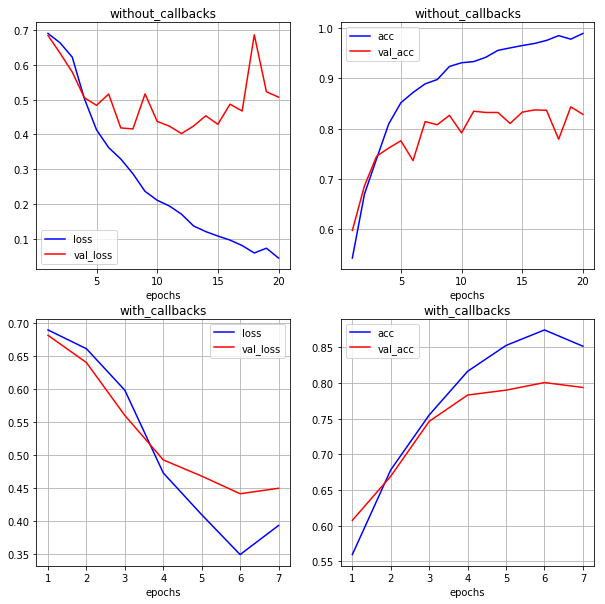

In [10]:
def plot_on_axis(ax,history,title,key1='loss',key2='val_loss'):
    value1 = history.history[key1]
    value2 = history.history[key2]
    epochs = range(1,len(value1)+1)
    ax.plot(epochs, value1, 'b', label=key1)
    ax.plot(epochs, value2, 'r', label=key2)
    ax.legend()
    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel('epochs')

titles = ['without_callbacks','with_callbacks']
plt.figure(figsize=(10,5*len(history_record)))
gs = gridspec.GridSpec(len(history_record),2)
for i, history in enumerate(history_record):
    ax1 = plt.subplot(gs[i,0])
    plot_on_axis(ax1,history,titles[i],key1='loss',key2='val_loss')
    ax2 = plt.subplot(gs[i,1])
    plot_on_axis(ax2,history,titles[i],key1='acc',key2='val_acc')
plt.savefig('{}/results_of_different_fit_param.png'.format(res_path))
plt.show()


#### 7.2.2 Introduction to TensorBoard: the Tensorflow visualization framework

In [12]:
max_features = 2000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len, name='embed'))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.MaxPool1D(5))
model.add(layers.Conv1D(32,7,activation='relu'))
model.add(layers.GlobalAvgPool1D())
model.add(layers.Dense(1))
print(model.summary())
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embed (Embedding)            (None, 500, 128)          256000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
_________________________________________________________________
None

In [15]:
# create the tensorboard log dir
tensor_log_path = '{}/res_c{}/my_log_dir'.format(cur_work_path,sectionnum)
if not os.path.exists(tensor_log_path):
    os.mkdir(tensor_log_path)
# create the callback
callbacks = [
    keras.callbacks.TensorBoard(
    log_dir=tensor_log_path,
#     histogram_freq=1,
#     embeddings_freq=1
    )
]
history = model.fit(x_train, y_train, epochs=3, 
                    batch_size=512, validation_split=0.2, 
                    callbacks=callbacks)

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 62s 3ms/step - loss: 0.6059 - acc: 0.7008 - val_loss: 0.5746 - val_acc: 0.6522
Epoch 2/3
20000/20000 [==============================] - 65s 3ms/step - loss: 0.5111 - acc: 0.7946 - val_loss: 0.4480 - val_acc: 0.8306
Epoch 3/3
20000/20000 [==============================] - 70s 3ms/step - loss: 0.4474 - acc: 0.8112 - val_loss: 0.9996 - val_acc: 0.6122


In [29]:
%%bash

tensorboard --logdir = ./res_c7_2/my_log_dir

Process is terminated.
